In [1]:
%load_ext autoreload
%autoreload 2

import sys
sys.path.insert(0, '../')

import os
import time
import h5py
import pickle
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import itertools
import scanpy as sc
from truncated_normal import truncated_normal as tn
from scipy.stats import ttest_ind

import figure_utils as utils

/opt/conda/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
/opt/conda/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)


In [2]:
# Load data
def load_mat_h5f(flname):
    h5f = h5py.File(flname,'r')
    X = h5f['dataset_1'][:]
    h5f.close()
    return X


def load_dataset(dirname, pref, get_features=False):
    
    X_path = os.path.join(dirname, pref, '%s_expr.txt'%(pref))
    Y_path = os.path.join(dirname, pref, '%s_labels.txt'%(pref))
    features_path = os.path.join(dirname, pref, '%s_features.txt'%(pref))

    if os.path.isfile(Y_path):
        Y = np.loadtxt(Y_path, dtype=str, delimiter='aSDFASDF')
    else:
        print('No labels found. Exiting.')
        return
    
    if os.path.isfile(X_path.replace('.txt', '.h5')):
        X = load_mat_h5f(X_path.replace('.txt', '.h5'))
    elif os.path.isfile(X_path):
        X = np.loadtxt(X_path).T
    else:
        print('No data found. Exiting.')
        return
       
    if get_features and os.path.isfile(features_path):
        features = np.loadtxt(features_path, dtype=str)
        return X, Y, features
    
    return X, Y

In [3]:
def evaluate_overclustering(adata, Y_oc, features, picklefile,
                            plot_stuff=True, ngenes=100, ignore_list=[]):
    
    if os.path.isfile(picklefile):
        results = pickle.load(open(picklefile, 'rb'))
    else:
        results = {}
    
    for ident0, ident1 in itertools.combinations(np.unique(Y_oc), 2):
        
        if ident0 in ignore_list or ident1 in ignore_list:
            continue

        print(ident0, ident1)
        
        np.random.seed(1)

        # Split preprocessed data
        y = adata.X[Y_oc == ident0]
        z = adata.X[Y_oc == ident1]

        # TN test using existing labels
        p_t = ttest_ind(y, z)[1]
        genes_to_test = np.argsort(p_t)[:ngenes] # Choose a bunch of genes based on t-test
        genes_of_interest = features[genes_to_test]

        if (ident0, ident1) not in results:
            p_tn, y, z = tn.tn_test(y, z, genes_to_test=genes_to_test,
                                    split_prop=0.5, eps=1e-2,
                                    verbose=True, learning_rate=1.,
                                    num_iters=10000, plot_likelihood=True,
                                    return_split=True)
            results[(ident0, ident1)] = (p_tn, y, z)
            pickle.dump(results, open(picklefile, 'wb'))
        else:
            p_tn, y, z = results[(ident0, ident1)]

        if plot_stuff:
            view_genes(y, z, features, genes_of_interest[:8], p_t=p_t, p_tn=p_tn)    
            
    return results


def get_diff_tups(Y, results, ngenes=100, nmean=10, verbose=False):
    
    out = []
    start = time.time()
    for ident0, ident1 in results.keys():
        p_tn, _, _ = results[(ident0, ident1)]
        p_t = np.sort(ttest_ind(adata.X[Y == ident0], adata.X[Y == ident1])[1])[:ngenes]
        gap = np.mean(-np.log10(p_t[:nmean]))-np.mean(-np.log10(p_tn[:nmean]))
        out.append((gap, ident0, ident1))
        if verbose:
            print('\rComparing %10s v %10s (%.2f s elapsed)' \
                  %(ident0, ident1, time.time()-start), end='')
            
    return out

    
def Kolodziejczyk_oc_experiment(adata, resolution, plot_stuff=True):

    # Overclustering
    sc.tl.louvain(adata, resolution=resolution)
    Y_oc = np.array(adata.obs['louvain'].astype(int))
    if plot_stuff:
        utils.plot_labels_legend(tsne[:, 0], tsne[:, 1], Y_oc)
        plt.show()

    picklefile = '%s_tntest_resolution%s.pickle'%(pref, resolution)
    results = evaluate_overclustering(adata, Y_oc, features, picklefile, plot_stuff=plot_stuff)
    
    return Y_oc, results

### Kolodziejczyk

In [4]:
dirname = '/root/mount/datasets/'
pref = 'Kolodziejczyk'
X, _ = load_dataset(dirname, pref, get_features=False)
features = np.arange(X.shape[1]).astype(str)
tsne = np.loadtxt(os.path.join(dirname, '%s/%s_reducedim_coor.txt'%(pref, pref)))

# Preprocessing
adata = sc.AnnData(X=X)
sc.pp.filter_cells(adata, min_genes=200)
sc.pp.filter_genes(adata, min_cells=3)
sc.tl.pca(adata, svd_solver='arpack')
sc.pp.neighbors(adata, n_neighbors=10, n_pcs=40)

/opt/conda/lib/python3.6/site-packages/sklearn/metrics/pairwise.py:257: RuntimeWarning: invalid value encountered in sqrt
  return distances if squared else np.sqrt(distances, out=distances)


0 1


/opt/conda/lib/python3.6/site-packages/scipy/stats/stats.py:3875: RuntimeWarning: invalid value encountered in sqrt
  denom = np.sqrt(svar * (1.0 / n1 + 1.0 / n2))
/opt/conda/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in greater
  return (self.a < x) & (x < self.b)
/opt/conda/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in less
  return (self.a < x) & (x < self.b)
/opt/conda/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:1821: RuntimeWarning: invalid value encountered in less_equal
  cond2 = cond0 & (x <= self.a)


0 2
1 2


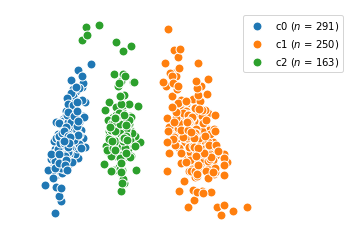

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:51: RuntimeWarning: divide by zero encountered in log10
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:51: RuntimeWarning: invalid value encountered in double_scalars


0 1 nan
1 2 -inf
0 2 -inf


In [5]:
Y1, results1 = Kolodziejczyk_oc_experiment(adata, 0.4, plot_stuff=False)

plt.figure(figsize=(4, 4))
utils.plot_labels_legend(tsne[:, 0], tsne[:, 1], np.array(['c%s'%(i) for i in Y1]), add_counts=True, s=80)
plt.legend(bbox_to_anchor=(1.4, 1))
plt.axis('off')
plt.savefig('figures/Kolodziejczyk_oc1_tsne.pdf', format='pdf', dpi=500, bbox_inches='tight')
plt.show()

d = get_diff_tups(Y1, results1)
for gap, c0, c1 in sorted(d, reverse=True)[:5]:
    print(c0, c1, gap)

0 1
0 2


/opt/conda/lib/python3.6/site-packages/scipy/stats/stats.py:3875: RuntimeWarning: invalid value encountered in sqrt
  denom = np.sqrt(svar * (1.0 / n1 + 1.0 / n2))
/opt/conda/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in greater
  return (self.a < x) & (x < self.b)
/opt/conda/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in less
  return (self.a < x) & (x < self.b)
/opt/conda/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:1821: RuntimeWarning: invalid value encountered in less_equal
  cond2 = cond0 & (x <= self.a)


0 3
0 4
0 5
1 2
1 3
1 4
1 5
2 3
2 4
2 5
3 4
3 5
4 5


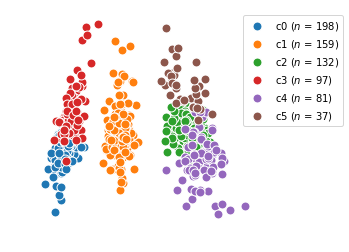

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:51: RuntimeWarning: divide by zero encountered in log10


2 5 13.443461319225765
0 3 12.561764196790214
4 5 11.462421049478943
2 4 3.929990569602923
3 5 -inf


In [6]:
Y2, results2 = Kolodziejczyk_oc_experiment(adata, 1.0, plot_stuff=False)

plt.figure(figsize=(4, 4))
utils.plot_labels_legend(tsne[:, 0], tsne[:, 1], np.array(['c%s'%(i) for i in Y2]), add_counts=True, s=80)
# utils.plot_labels_legend(tsne[:, 0], tsne[:, 1], np.array(['c%s'%(i) for i in Y2]), add_counts=True)
plt.legend(bbox_to_anchor=(1.4, 1))
plt.axis('off')
plt.savefig('figures/Kolodziejczyk_oc2_tsne.pdf', format='pdf', dpi=500, bbox_inches='tight')
plt.show()

d = get_diff_tups(Y2, results2)
for gap, c0, c1 in sorted(d, reverse=True)[:5]:
    print(c0, c1, gap)